# Problem 3, Question 1: Temperature Prediction

Train four MLPRegressor models (one per big core) to predict temperature values for the next time step based on the features of the current time step. Exclude power features (total_watts, w_big, w_little, w_gpu, w_mem).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# Power features to exclude
POWER_FEATURES = ['total_watts', 'w_big', 'w_little', 'w_gpu', 'w_mem']

# Big core temperature columns (targets)
TEMP_COLS = ['temp4', 'temp5', 'temp6', 'temp7']


def prepare_data(df):
    """
    Prepare features (X) and targets (y) for next time step prediction.
    Features: usage_c4-c7, temp4-7, temp_gpu, freq_big_cluster (scaled by 1e9)
    Excludes all power features.
    """
    df = df.copy()
    df['freq_big_cluster'] = df['freq_big_cluster'] / 1_000_000_000

    all_cols = df.columns.tolist()
    feature_cols = [c for c in all_cols if c not in POWER_FEATURES]

    X = df[feature_cols].values[:-1]
    y_dict = {col: df[col].values[1:] for col in TEMP_COLS}

    return X, y_dict, feature_cols


def train_models(X_train, y_train_dict):
    """Train four MLPRegressor models, one per big core."""
    models = {}
    for col in TEMP_COLS:
        model = MLPRegressor(
            hidden_layer_sizes=(128, 64, 32),
            activation='relu',
            random_state=42
        )
        model.fit(X_train, y_train_dict[col])
        models[col] = model
    return models

In [ ]:
def evaluate_and_plot(models, X_test, y_test_dict, dataset_name, output_prefix):
    """Evaluate models, compute MSE, and create plot for core 4."""
    mse_dict = {}
    predictions = {}

    for col in TEMP_COLS:
        y_true = y_test_dict[col]
        y_pred = models[col].predict(X_test)
        mse = mean_squared_error(y_true, y_pred)
        mse_dict[col] = mse
        predictions[col] = y_pred

    time_s = np.arange(len(y_test_dict['temp4'])) * 0.2

    plt.figure(figsize=(10, 6))
    plt.plot(time_s, y_test_dict['temp4'], label='True temperature', color='blue')
    plt.plot(time_s, predictions['temp4'], label='Predicted temperature', color='red', linestyle='--')
    plt.xlabel('Time [s]')
    plt.ylabel('Temperature [C]')
    plt.title(f'Core 4 Temperature Prediction - {dataset_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(output_prefix + '_core4_prediction.png', dpi=150)
    plt.show()
    plt.close()

    return mse_dict

In [4]:
# Load training data and train models
train_df = pd.read_csv('training_dataset.csv')
X_train, y_train_dict, feature_cols = prepare_data(train_df)

print("Training MLPRegressor models...")
models = train_models(X_train, y_train_dict)

Training MLPRegressor models...


In [5]:
# Load test data and evaluate
blackscholes_df = pd.read_csv('testing_blackscholes.csv')
bodytrack_df = pd.read_csv('testing_bodytrack.csv')

X_blackscholes, y_blackscholes, _ = prepare_data(blackscholes_df)
X_bodytrack, y_bodytrack, _ = prepare_data(bodytrack_df)

Evaluating on blackscholes...


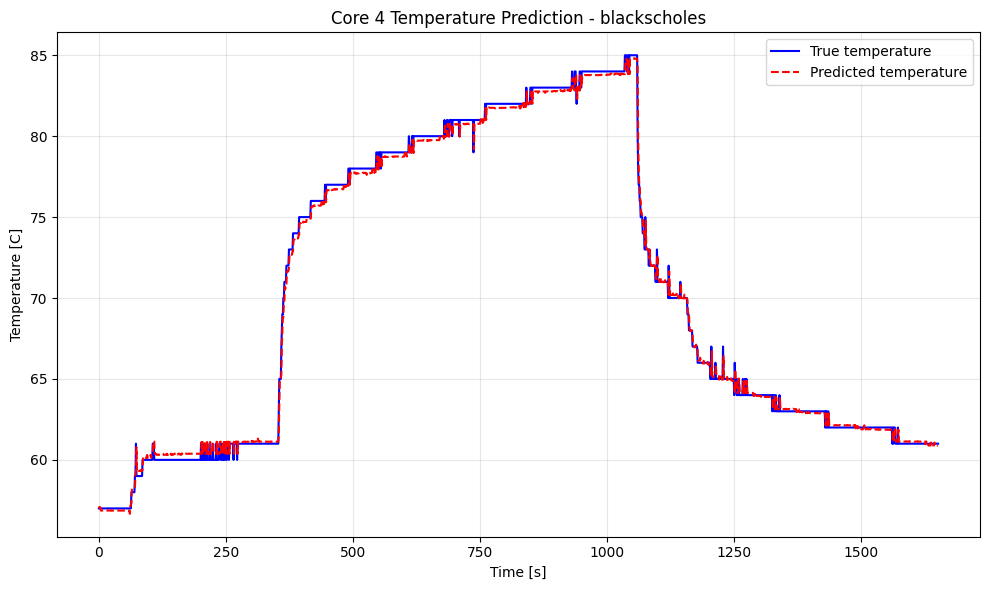

In [6]:
# Evaluate and plot - blackscholes
print("Evaluating on blackscholes...")
mse_blackscholes = evaluate_and_plot(
    models, X_blackscholes, y_blackscholes,
    'blackscholes', 'blackscholes'
)

Evaluating on bodytrack...


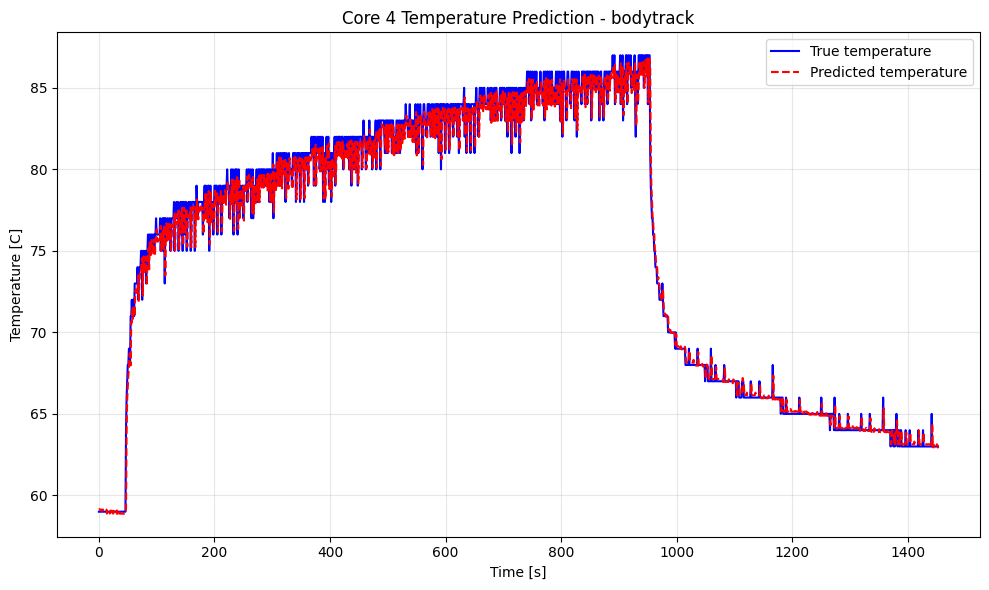

In [7]:
# Evaluate and plot - bodytrack
print("Evaluating on bodytrack...")
mse_bodytrack = evaluate_and_plot(
    models, X_bodytrack, y_bodytrack,
    'bodytrack', 'bodytrack'
)

In [8]:
# Table 5
print("=" * 60)
print("Table 5")
print("=" * 60)
print(f"{'Dataset':<15} {'Test MSE (Core 4)':<20} {'Test MSE (Core 5)':<20} {'Test MSE (Core 6)':<20} {'Test MSE (Core 7)':<20}")
print("-" * 60)
print(f"{'blackscholes':<15} {mse_blackscholes['temp4']:<20.6f} {mse_blackscholes['temp5']:<20.6f} {mse_blackscholes['temp6']:<20.6f} {mse_blackscholes['temp7']:<20.6f}")
print(f"{'bodytrack':<15} {mse_bodytrack['temp4']:<20.6f} {mse_bodytrack['temp5']:<20.6f} {mse_bodytrack['temp6']:<20.6f} {mse_bodytrack['temp7']:<20.6f}")
print("=" * 60)

all_mse = list(mse_blackscholes.values()) + list(mse_bodytrack.values())
if all(m < 1.5 for m in all_mse):
    print("\nAll Test MSE values are below 1.5 (requirement satisfied).")
else:
    print("\nWarning: Some Test MSE values exceed 1.5.")

Table 5
Dataset         Test MSE (Core 4)    Test MSE (Core 5)    Test MSE (Core 6)    Test MSE (Core 7)   
------------------------------------------------------------
blackscholes    0.156752             0.153057             0.326226             0.114536            
bodytrack       1.165708             1.117478             1.392798             0.661181            

All Test MSE values are below 1.5 (requirement satisfied).


# Question 2: Techniques to Improve Regressor Performance

Two or more techniques that can improve the temperature prediction model:

1. **Feature scaling/normalization**: Apply StandardScaler or MinMaxScaler to non-temperature features (e.g., usage_c4–usage_c7, freq_big_cluster). Scaling puts predictors on a similar scale so the MLP converges faster and often generalizes better.
2. **Temporal features**: Add lagged temperatures (e.g., from t−2, t−3) or rolling statistics (moving average, standard deviation) as features. This helps capture dynamics and thermal inertia.

<!-- 
1. **Feature scaling/normalization**: Apply StandardScaler or MinMaxScaler to normalize the input features (except temperature features as specified). This helps the MLP converge faster and often achieves better generalization.

2. **Additional temporal features**: Use lagged temperature values (e.g., temperatures from t-2, t-3) or rolling statistics (moving average, std) as features to capture longer-term thermal dynamics.

3. **Recurrent models (LSTM/GRU)**: Replace MLP with temporal models that explicitly model sequential dependencies, which can capture thermal inertia and transient behavior better.

4. **Ensemble methods**: Combine multiple models (e.g., bagging, stacking) or use cross-validation to reduce variance and improve robustness across different workload patterns.

5. **Hyperparameter tuning**: Use grid search or Bayesian optimization to tune hidden_layer_sizes, learning rate, alpha (regularization), and batch size. -->